In [1]:
# Libraries import
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

## DATA ANALYSYS

In [3]:
# Dataset import
url = "https://raw.githubusercontent.com/cp9321/RNNs-comparison/main/NKE_2006-01-01_to_2018-01-01.csv" 
download = requests.get(url).content

ds = pd.read_csv(io.StringIO(download.decode('utf-8')), index_col='Date', parse_dates=['Date'])
ds.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.85,10.92,10.67,10.74,18468800,NKE
2006-01-04,10.71,10.80,10.67,10.69,15832000,NKE
2006-01-05,10.69,10.83,10.69,10.76,9256000,NKE
2006-01-06,10.79,10.83,10.71,10.72,7573600,NKE
2006-01-09,10.72,10.98,10.72,10.88,10441600,NKE


**Analysis** Importiamo il dataset, caricato in locale nello spazio di archiviazione della sessione. Poi grazie alla funzione head, controlliamo che l'operazione sia avvenuta correttamente e diamo una prima occhiata alle colonne che lo compongono.

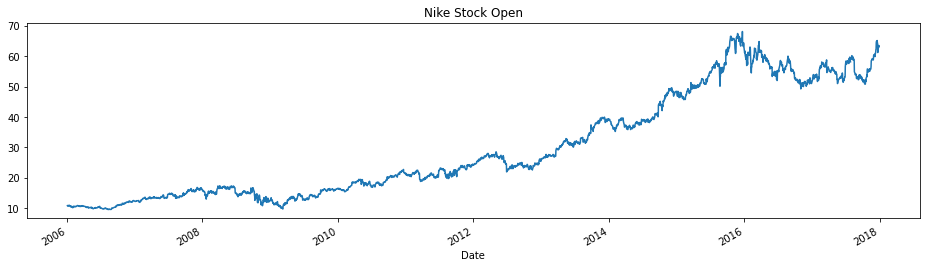

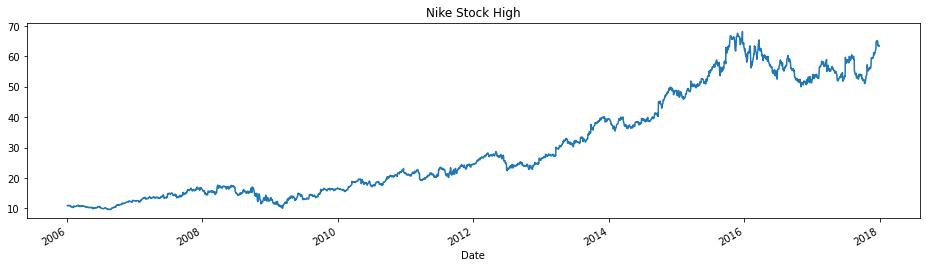

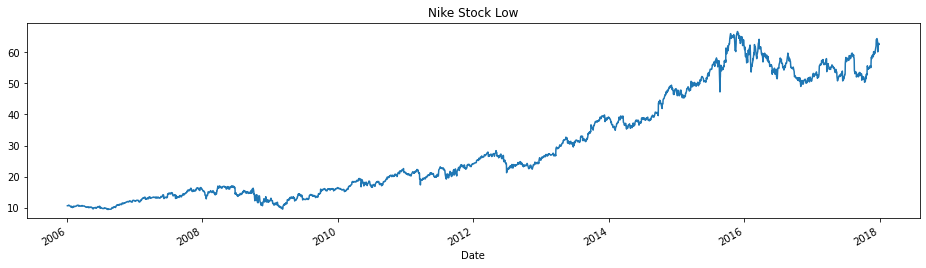

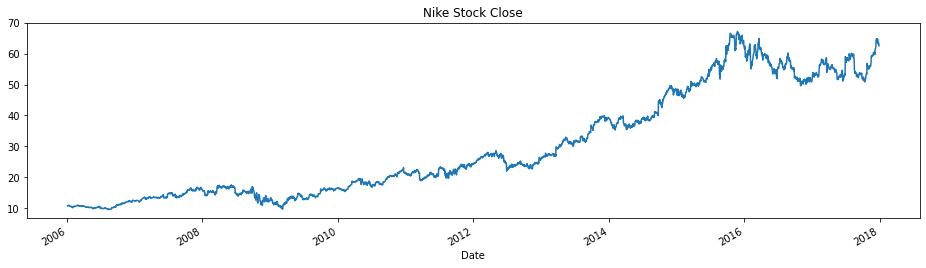

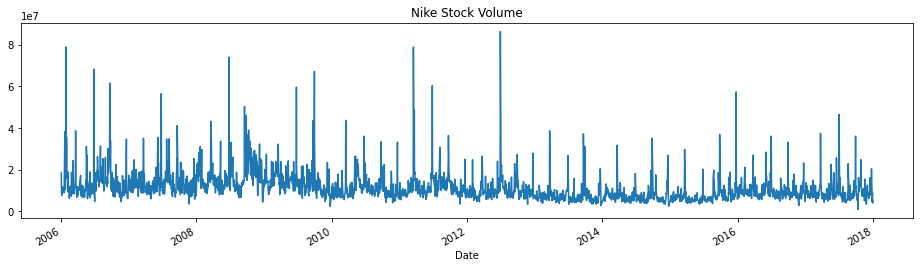

In [ ]:
# Visualize our data
dataset = ds.drop(columns='Name')

for (i, name) in enumerate (dataset.columns):
  dataset[name].plot(figsize=(16,4))
  plt.title(f"Nike Stock {name}")
  plt.show()

**Analysis** Visualizziamo graficamente i nostri dati plottandoli in dei grafici. Vediamo che ci sono quattro feature (Open, High, Low e Closure) molto simili tra loro, sia come andamento, che come scala; mentre ce n'è una estremamente diversa per andamento e scala, che è Volume.

In [ ]:
# Choose train/test split and the feature
training_set = dataset[:'2015'].iloc[:,1:2].values 
test_set = dataset['2016':].iloc[:,1:2].values

**Analysis** Eseguiamo lo split del dataset in training e test set. Come è pratica comune con questo tipo di dati, lo facciamo separando i dati su un certo anno. 

In [ ]:
# Create training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
X_train = []
y_train = []
for i in range(60,2517):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

**Analysis** Scaliamo il training set e impostiamo il numero di valori (istanti di tempo) precedenti, che ogni elemento del training set deve avere. Questo è il passaggio chiave dove si "crea" la memoria della nostra LSTM/GRU.

## LSTM

In [ ]:
# Create LSTM model
model = Sequential() 
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), dropout=0.25))
model.add(LSTM(units=50, return_sequences=True, dropout=0.25))
model.add(LSTM(units=50, dropout=0.25))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


**Analysis** La nostra rete si compone di quattro strati impilati sequenzialmente: tre strati di LSTM, ed un Dense finale (che è la denominazione che Keras da al layer lineare totalmente connesso). Qui è molto importante il parametro return_sequences che se impostato a true ci consente di resitituire in output una intera sequenza e non un singolo valore. Inoltre abbiamo settato su ogni livello un dropout pari a un quarto, il che significa che i nodi vengono "disattivati" con probabilità di uno su quattro.

In [ ]:
# Compile and fit
model.compile(optimizer=SGD(learning_rate=0.005, decay=1e-6, momentum=0.5),loss='mean_squared_error')
model.fit(X_train,y_train,epochs=35,batch_size=125)

Epoch 1/35
20/20 [==============================] - 10s 226ms/step - loss: 0.0748
Epoch 2/35
20/20 [==============================] - 3s 156ms/step - loss: 0.0479
Epoch 3/35
20/20 [==============================] - 3s 165ms/step - loss: 0.0446
Epoch 4/35
20/20 [==============================] - 4s 189ms/step - loss: 0.0414
Epoch 5/35
20/20 [==============================] - 4s 199ms/step - loss: 0.0384
Epoch 6/35
20/20 [==============================] - 3s 166ms/step - loss: 0.0351
Epoch 7/35
20/20 [==============================] - 3s 167ms/step - loss: 0.0312
Epoch 8/35
20/20 [==============================] - 4s 216ms/step - loss: 0.0278
Epoch 9/35
20/20 [==============================] - 3s 162ms/step - loss: 0.0240
Epoch 10/35
20/20 [==============================] - 3s 161ms/step - loss: 0.0198
Epoch 11/35
20/20 [==============================] - 3s 163ms/step - loss: 0.0163
Epoch 12/35
20/20 [==============================] - 4s 207ms/step - loss: 0.0129
Epoch 13/35
20/20 [=====

**Analysis** Per la nostra rete, abbiamo scelto SGD (Stochastic Gradient Descent) come optimizer (seppur sia stato provato anche RMSProp, ma senza miglioramenti visibili) e la MSE (l'errore quadratico medio) come loss. Il learning rate e il momentum sono stati settati su dei valori tali da non far imparare troppo velocemente la rete. Inoltre si è usato anche il decay per mantenere bassa la magnitude dei pesi. Per quanto riguarda la batch size, il valore di 125 è stato impostato in modo da avere circa 20 iterazioni per epoca, visto che gli esempi del training set sono circa 2500, ma abbiamo rilevato che questo non impatta molto sul risultato finale. Il numero di epoche è impostato su 35, soluzione che ci consente di mantenere bassi i tempi di esecuzione e di raggiungere comunque l'appiattimento della curva delle loss (segnale che la rete non sta imparando più), cosa che avviene attorno alle 30 epoche.

In [ ]:
# Creating test set
tf.keras.utils.plot_model(model)
dataset_total = pd.concat((dataset["High"][:'2015'],dataset["High"]['2016':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
X_test = []
for i in range(60,563):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

**Analysis** Analogmanete a quanto fatto per il training set, creiamo il test set, che ovviamente differisce perche non ha valori target (quindi non esiste y_train)

In [ ]:
# Predict
predicted_stock_price = model.predict(X_test, verbose=0)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

**Analysis** L'unica particolarità aggiunta alla predict è la verbosità impostata su zero, per non vedere le barre di avanzamento temporale dell'operazione.

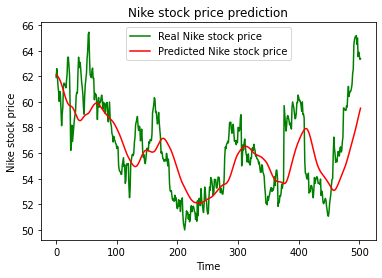

The root mean squared error is 2.472470683011645.


In [ ]:
# Results
def plot_predictions(test,predicted):
    plt.plot(test, color='green',label='Real Nike stock price')
    plt.plot(predicted, color='red',label='Predicted Nike stock price')
    plt.title('Nike stock price prediction')
    plt.xlabel('Time')
    plt.ylabel('Nike stock price')
    plt.legend()
    plt.show()

plot_predictions(test_set,predicted_stock_price)

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

return_rmse(test_set,predicted_stock_price)

**Analysis** L'andamento della curva dei prezzi delle azioni predetti dalla nostra rete, ricalca abbastanza bene quello reale. Seppur i grossi picchi (in alto e in basso) risultano molto smussati, e tutta la curva è leggermente traslata verso il basso. L'RMSE varia tra 2.3 e 2.6. 

## GRU

In [ ]:
# Create GRU model
model2 = Sequential()
model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), dropout=0.25))
model2.add(GRU(units=50, return_sequences=True, dropout=0.25))
model2.add(GRU(units=50, dropout=0.25))
model2.add(Dense(units=1))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38,601
Trainable params: 38,601
Non-trainable params: 0
_________________________________________________________________


**Analysis** L'impostazione per la rete in versione GRU è la stessa di prima, scelta dettata dalla voglia di fare un confronto alla pari tra le due. L'unica differenza che possiamo osservare, grazie alla funzione summary, è come la GRU a parità di numero di unità e di livelli, abbia molti meno parametri della LSTM (meno di 40mila contro oltre 50mila).

In [ ]:
# Compile and fit
model2.compile(optimizer=SGD(learning_rate=0.005, decay=1e-6, momentum=0.5),loss='mean_squared_error')
model2.fit(X_train,y_train,epochs=35,batch_size=125)

Epoch 1/35
20/20 [==============================] - 11s 185ms/step - loss: 0.0969
Epoch 2/35
20/20 [==============================] - 5s 247ms/step - loss: 0.0649
Epoch 3/35
20/20 [==============================] - 3s 166ms/step - loss: 0.0577
Epoch 4/35
20/20 [==============================] - 3s 169ms/step - loss: 0.0516
Epoch 5/35
20/20 [==============================] - 4s 224ms/step - loss: 0.0464
Epoch 6/35
20/20 [==============================] - 3s 167ms/step - loss: 0.0410
Epoch 7/35
20/20 [==============================] - 3s 174ms/step - loss: 0.0360
Epoch 8/35
20/20 [==============================] - 3s 157ms/step - loss: 0.0320
Epoch 9/35
20/20 [==============================] - 4s 228ms/step - loss: 0.0277
Epoch 10/35
20/20 [==============================] - 4s 185ms/step - loss: 0.0239
Epoch 11/35
20/20 [==============================] - 3s 158ms/step - loss: 0.0205
Epoch 12/35
20/20 [==============================] - 6s 303ms/step - loss: 0.0174
Epoch 13/35
20/20 [=====

**Analysis** Anche per la compile e la fit, stessi iperparametri usati per la LSTM di prima, e stavolta osserviamo che la curva delle loss, parte un po' più alta e si appiattisce leggerissimamente prima, ma comunque sempre verso la 30esima epoca.

In [ ]:
# Predict
predicted_stock_price2 = model2.predict(X_test, verbose=0)
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price2)

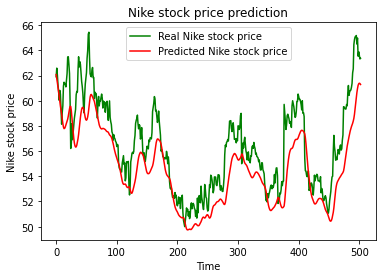

The root mean squared error is 2.381452770146121.


In [ ]:
#Results
plot_predictions(test_set,predicted_stock_price2)

return_rmse(test_set,predicted_stock_price2)

**Analysis** La GRU, pur sempre con la lieve traslazione verso il basso, riesce a replicare molto meglio l'andamento della curva reale, specie nei picchi, che seppur leggermente smussati, nella curva predetta sono replicati pressoche tutti. Anche il RMSE mostra dei miglioramenti rispetto a prima, in quanto ora si attesta sui 2.1-2.4

## SEQUENCE GENERATION

In [ ]:
model3 = Sequential()
model3.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model3.add(Dropout(0.2))
model3.add(GRU(units=50, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(GRU(units=50, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(GRU(units=50))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))
model3.summary()
    
model3.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9),loss='mean_squared_error')
model3.fit(X_train,y_train,epochs=25,batch_size=125)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 60, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 gru_4 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 50)               

**Analysis** Per questo caso, usiamo ovviamente la GRU, visto che abbiamo appena scoperto come si comporti meglio rispetto alla LSTM, ma usiamo una configurazione un po' più "potente". Abbiamo aggiunto uno strato di GRU, e ridotto il dropout a uno su cinque. Per quanto riguarda gli iperparametri è stato aumentato il learning rate e il momentum, per far si che la rete impari più velocmente. Di conseguenza viene ridotto il numero di epoche, dato che ora la loss si appiattisce già verso la 20esima.

In [ ]:
# Generate sequence and predicting
initial_sequence = X_train[2397,:] 
sequence = []
for i in range(503):
    new_prediction = model3.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1), verbose=0)
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(503,1))

**Analysis** Stavolta creiamo il test set, generando una sequenza in cui ogni esempio non è legato ai suoi valori precedenti. Andremo quindi a fare predizioni senza basarci su questi ultimi.

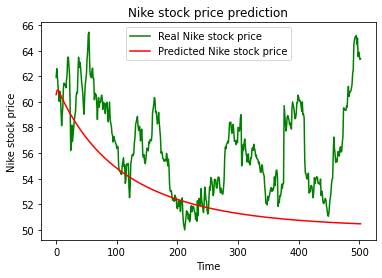

The root mean squared error is 4.852281542138089.


In [ ]:
# Results
plot_predictions(test_set,sequence)
return_rmse(test_set,sequence)

**Analysis** Questo caso, che può essere considerato il vero benchmark di una rete di questo tipo, perchè è molto aderente ad una applicazione reale, ci mostra come il RMSE e la curva delle predizioni, siano ben altra cosa rispetto a prima. Tuttavia, il fatto che la curva sia appunto una curva e non una retta, e il fatto che l'errore oscilli tra 4 e 7, sono già degli ottimi punti di partenza.